In [35]:
import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
import math
import pandas as pd
import random
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
 
from funciones import *
from solvers_listos import generar_ruta, graficar_rutas 
# from instancia import ubis, cap_tpte, info_locales
# from instancia import G, color_nodos, color_arcos, ancho_edges
from ruteo_alns import ruteo_ALNS

random.seed(1)
np.random.seed(1)

# Instancia

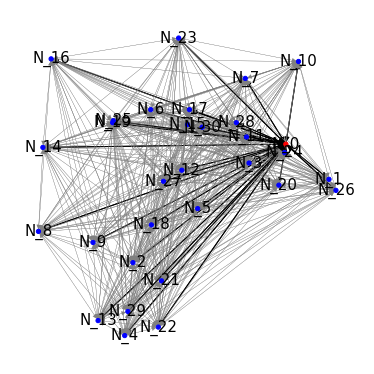

{'Inv': 3773, 'Up': 1000000, 'Low': 0, 'Prod': 1508, 'h': 0.3, 'coord_x': 407, 'coord_y': 331, 'pos': (407, 331)}
{'Inv': 0, 'Up': 80, 'Low': 0, 'Prod': 40, 'h': 0.33, 'coord_x': 475, 'coord_y': 277, 'pos': (475, 277)}
{'Inv': 0, 'Up': 48, 'Low': 0, 'Prod': 24, 'h': 0.41, 'coord_x': 166, 'coord_y': 149, 'pos': (166, 149)}
{'Inv': 0, 'Up': 180, 'Low': 0, 'Prod': 60, 'h': 0.47, 'coord_x': 349, 'coord_y': 302, 'pos': (349, 302)}
{'Inv': 0, 'Up': 154, 'Low': 0, 'Prod': 77, 'h': 0.36, 'coord_x': 153, 'coord_y': 37, 'pos': (153, 37)}
{'Inv': 0, 'Up': 186, 'Low': 0, 'Prod': 62, 'h': 0.48, 'coord_x': 268, 'coord_y': 232, 'pos': (268, 232)}
{'Inv': 0, 'Up': 123, 'Low': 0, 'Prod': 41, 'h': 0.24, 'coord_x': 194, 'coord_y': 384, 'pos': (194, 384)}
{'Inv': 0, 'Up': 192, 'Low': 0, 'Prod': 64, 'h': 0.48, 'coord_x': 343, 'coord_y': 432, 'pos': (343, 432)}
{'Inv': 0, 'Up': 112, 'Low': 0, 'Prod': 56, 'h': 0.49, 'coord_x': 17, 'coord_y': 197, 'pos': (17, 197)}
{'Inv': 0, 'Up': 32, 'Low': 0, 'Prod': 16, '

In [36]:
G, ubis, cap_tpte, info_locales = crear_grafo_inicial(archivo= 'n30empty.xlsx' ,plot=True)
for nodo in G.nodes(data=True):
    si_o_no = random.randint(0,1)
    if False and nodo[0] != 'N_0':
        up = nodo[1]['Up']
        new_d = random.randint(int(up*0.25), int(up*0.75))
        G.nodes[nodo[0]]['Prod'] = new_d
        G.nodes[nodo[0]]['Inv'] = up - new_d

    print(G.nodes(data=True)[nodo[0]])

In [37]:
# def reaccion_inventario(grafo, mu, sd, alfa = 0.05):
#     """
#     Función que verifica que locales deben ser visitados en base a su inventario actual. 
#     En caso de que el inventario se encuentre bajo el umbral de tolerancia, se retorna True.
#     """
#     grafo = G.copy()
#     visitas = {nodo : False for nodo in G.nodes()}
#     for nodo in grafo.nodes(data=True):
#         id_nodo = int(nodo[0][2:])-1
#         media = mu[id_nodo]
#         desviacion = sd[id_nodo]
#         s = media + norm.ppf((1 - alfa)/2) * desviacion  #Stock de segrafouridad
#         if nodo[1]['Inv'] <= s:
#             visitas[nodo[0]] = True
    
#     return visitas

In [38]:


#ejemplo demanda historica

muestra = False

if muestra:
    dem_historico = simular_demanda_previa(G, dist = 'n', T=1000, ruido=0.05) 
    demanda = {nodo: dem_historico[nodo][-1] for nodo in dem_historico.keys()}
    print(demanda)
    print(dem_historico.keys())
    plt.figure(figsize=(10, 5))
    plt.plot(demanda.values(), 'o', color='black') 
    # for nodo in dem_historico.keys():
    #     if nodo != 'N_0':
    #         # plt.plot(dem_historico[nodo])
    #         plt.plot(smooth(dem_historico[nodo], 10))
    plt.xlabel('Días')
    plt.ylabel('Demanda')
    plt.xticks(np.arange(len(demanda)), demanda.keys())
    plt.title('Demanda histórica')
    plt.show()


In [39]:
muestra = False

if muestra:
    dem_historico = simular_demanda_previa(G, dist = 'n', T=1000, ruido = 0.05) 
    demanda = {nodo: dem_historico[nodo][-1] for nodo in dem_historico.keys()}
    data = {nodo: dem_historico[nodo][1:] for nodo in dem_historico.keys()}
    y = [SEDA(data[nodo], historia=False, alpha = 0.5) for nodo in data.keys()]
    medias = [np.mean(data[nodo]) for nodo in data.keys()]
    ind = np.arange(len(y))

    # y = [SEDA(dem_historico[nodo], pron=True, alpha = 0.5) for nodo in set(dem_historico)-set(['N_0'])]
    # medias = [np.mean(dem_historico[nodo]) for nodo in set(dem_historico)-set(['N_0'])]
    # ind = np.arange(len(y))
    
    # print(y)
    ancho = 0.3
    plt.figure(figsize=(10, 5))
    plt.plot(y, 'o', label='Pronóstico', color='red')
    plt.plot(medias, 'o', label='Promedio', color='blue')
    plt.plot(demanda.values(), 'o', label='Realización', color='black')
    # plt.bar(ind, y, width=ancho, label='Pronóstico', color='red')
    # plt.bar(ind + ancho, medias, width=ancho, label='Promedio', color='blue')
    plt.xticks(ind + ancho / 2, [f'N_{i}' for i in range(1,len(y)+1)])

    plt.xlabel('Local')
    plt.ylabel('Demanda')
    plt.title('Demanda: Pronóstico y realización para t+1')
    plt.legend()
    plt.show()

In [40]:


# Gprima, d, ins = realizacion_demanda(G)

# for nodo in Gprima.nodes(data=True):
#     print(nodo[0],nodo[1]['Inv'])

def proactiva_inventario(G, pronostico, mu, sd, alfa = 0.05, tolerancia = 0.5):
    """
    Función que verifica que locales deben ser visitados en base a su inventario. 
    En caso de que el inventario se encuentre bajo el umbral de tolerancia, se retorna True.
    """
    visitas = {nodo : False for nodo in G.nodes()}
    for nodo in G.nodes(data=True):
        id_nodo = int(nodo[0][2:])-1
        media = mu[id_nodo]
        desviacion = sd[id_nodo]
        s = media + norm.ppf((1 - alfa)/2)* desviacion  #Stock de seguridad
        if nodo[1]['Inv'] <= s:
            visitas[nodo[0]] = True
            
    for nodo in G.nodes(data=True):
        mean = nodo[1]['Prod'] + mu
        sd = nodo[1]['Prod'] * sigma
        l_inf, l_sup = IC_nrm(mean, sd, alfa = 0.95)
        pronostico = l_sup
        if nodo[1]['Inv'] - pronostico <= tolerancia * nodo[1]['Up']:
            visitas[nodo[0]] = True
    
    return visitas



In [41]:
dem_historico_test = simular_demanda_previa(G, dist = 'n', T=1000) 
mu_d = [np.mean(dem_historico_test[nodo]) for nodo in dem_historico_test.keys()]    
sd_d = [np.std(dem_historico_test[nodo]) for nodo in dem_historico_test.keys()]
vis = reaccion_inventario(G, mu_d, sd_d)
np.sum(mu_d)

1508.6716389138373

In [42]:
def simular_ejecucion_R(grafo_inicial = G, T=1):
    # Inicializar variables     
    # ---------------------
    G0 = grafo_inicial.copy()
    matriz_dst = calcular_matriz_dist(G0)
    ubicaciones = list(G0.nodes()) # Lista de ubicaciones
    inventarios = [[G0.nodes(data=True)[i]['Inv'] for i in ubicaciones]] # Lista de inventarios
    h = [G0.nodes(data=True)[i]['h'] for i in ubicaciones] # Lista de costos de inventario
    rutas = {t : [] for t in range(T)} # Lista de rutas
    dem_historico = simular_demanda_previa(G0, dist = 'n', T=1000) 
    perdido = 0
    print("Inventario inicial: ")
    for nodo in G0.nodes(data=True):
            print(nodo[0],nodo[1]['Inv'])
    print("\n")

    for t in range(T):
        mu_demanda = [np.mean(dem_historico[nodo]) for nodo in dem_historico.keys()]    
        sd_demanda = [np.std(dem_historico[nodo]) for nodo in dem_historico.keys()]
        # pronostico = [pronostico_SEDA(dem_historico[nodo], T = 10, pron = True, alpha=0.1, beta=0.1, theta=0.5) for nodo in dem_historico.keys()]

        # Estrategia Reactiva (R)  
        # print([G0.nodes(data=True)[i]['Inv'] for i in ubicaciones])
        visitas_reaccion = reaccion_inventario(G0, mu_demanda, sd_demanda)
        # print("Visitas reacción: ", visitas_reaccion)
        if sum(visitas_reaccion.values()) == 0:
            print("No hay locales que visitar")
            rutas[t] = []

        else:    
            ruta_R, largo_ruta_R = generar_ruta(G0, matriz_dst, visitas_reaccion) #devuelve la ruta a realizar
            rutas[t] = ruta_R
            print(f"Ruta {t}: ", ruta_R )
            G0, stock = ejecutar_ruta(G0, ruta_R, matriz_dst)
            
        G0, demanda, insatisfecho = realizacion_demanda(G0)
        perdido += insatisfecho

        inventarios.append([G0.nodes(data=True)[i]['Inv'] for i in ubicaciones])
        
        # costo = sum([h[i]*inventarios[i] for i in range(len(inventarios))])
        
        for nodo in ubicaciones:
            if nodo != 'N_0':
                dem_historico[nodo].append(demanda[nodo])


    print('\n')
    print("Inventario final: ")
    for nodo in G0.nodes(data=True):
        print(nodo[0],nodo[1]['Inv'])
    print(f'Demanda perdida total: {perdido} | Demanda perdida promedio: {perdido/T}')
    
    return rutas, dem_historico
        
        
mis_rutas, dem_historico = simular_ejecucion_R(grafo_inicial = G, T = 365)
        

Inventario inicial: 
N_0 3773
N_1 0
N_2 0
N_3 0
N_4 0
N_5 0
N_6 0
N_7 0
N_8 0
N_9 0
N_10 0
N_11 0
N_12 0
N_13 0
N_14 0
N_15 0
N_16 0
N_17 0
N_18 0
N_19 0
N_20 0
N_21 0
N_22 0
N_23 0
N_24 0
N_25 0
N_26 0
N_27 0
N_28 0
N_29 0
N_30 0




Ruta 0:  ['N_0', 'N_24', 'N_11', 'N_28', 'N_30', 'N_15', 'N_17', 'N_6', 'N_19', 'N_25', 'N_23', 'N_7', 'N_10', 'N_1', 'N_26', 'N_20', 'N_3', 'N_5', 'N_12', 'N_27', 'N_18', 'N_2', 'N_21', 'N_22', 'N_13', 'N_4', 'N_29', 'N_9', 'N_8', 'N_14', 'N_16', 'N_0']
Ruta 1:  ['N_0', 'N_10', 'N_9', 'N_4', 'N_0']
Ruta 2:  ['N_0', 'N_24', 'N_11', 'N_28', 'N_30', 'N_17', 'N_15', 'N_12', 'N_27', 'N_19', 'N_25', 'N_23', 'N_7', 'N_10', 'N_1', 'N_22', 'N_29', 'N_4', 'N_13', 'N_2', 'N_9', 'N_8', 'N_14', 'N_16', 'N_0']
Ruta 3:  ['N_0', 'N_11', 'N_3', 'N_1', 'N_26', 'N_20', 'N_5', 'N_18', 'N_2', 'N_21', 'N_4', 'N_9', 'N_8', 'N_25', 'N_30', 'N_6', 'N_16', 'N_0']
Ruta 4:  ['N_0', 'N_24', 'N_28', 'N_10', 'N_7', 'N_23', 'N_30', 'N_12', 'N_27', 'N_25', 'N_19', 'N_29', 'N_0']
Ruta 5:  ['N_0', 'N_11', 'N_28', 'N_30', 'N_15', 'N_17', 'N_25', 'N_16', 'N_14', 'N_8', 'N_9', 'N_13', 'N_4', 'N_29', 'N_22', 'N_21', 'N_2', 'N_18', 'N_27', 'N_3', 'N_20', 'N_1', 'N_26', 'N_0']
Ruta 6:  ['N_0', 'N_24', 'N_28', 'N_10', 'N_23',

In [43]:
def simular_ejecucion_P_LS(grafo_inicial = G, T=1, F=1, cap = cap_tpte):
    # Inicializar variables     
    # ---------------------
    G0 = grafo_inicial.copy()
    matriz_dst = calcular_matriz_dist(G0)
    ubicaciones = list(G0.nodes()) # Lista de ubicaciones
    inventarios = [G0.nodes(data=True)[i]['Inv'] for i in ubicaciones] # Lista de inventarios
    h = [G0.nodes(data=True)[i]['h'] for i in ubicaciones] # Lista de costos de inventario
    rutas = {t : None for t in range(T)} # Lista de rutas
    dem_historico = simular_demanda_previa(G0, dist = 'n', T=1000) 
    perdido = 0
    print("Inventario inicial: ")
    for nodo in G0.nodes(data=True):
            print(nodo[0],nodo[1]['Inv'])
    print("\n")

    for t in range(T):
        pronostico = {int(nodo[2:]):
                pronostico_SEDA(dem_historico[nodo], T = 1, pron = True, alpha=0.2, beta=0.1, theta=0.5)[0]
                for nodo in dem_historico.keys()}
        # print(pronostico)
         
        ruta_P = ruteo_ALNS(G0, pronostico, cap = cap, F = F, ruta = True, MRT = 10) + ['N_0']
        rutas[t] = ruta_P
        print(f"Ruta {t}: ", ruta_P )
        # visitas_proactiva = proactiva_inventario(G0, tolerancia = 0.2, dist = 'n', mu = 0, sigma = 0.1, M = 1000)

        G0, stock = ejecutar_ruta(G0, ruta_P, matriz_dst)
        G0, demanda, insatisfecho = realizacion_demanda(G0)
        
        perdido += insatisfecho

        #Actualizo demandas
        for nodo in ubicaciones:
            if nodo != 'N_0':
                dem_historico[nodo].append(demanda[nodo])


    print('\n')
    print("Inventario final: ")
    for nodo in G0.nodes(data=True):
        print(nodo[0],nodo[1]['Inv'])
    print(f'Demanda perdida total: {perdido} | Demanda perdida promedio: {perdido/T}')        

    graficar_rutas(rutas, G0)

# simular_ejecucion_P(grafo_inicial = G, T = 5, cap = 871)

In [44]:
from ruteo_alns import ruteo_ALNS
cap_tpte = 871
def simular_ejecucion_P_ALNS(grafo_inicial = G, T=1, F=1, cap = cap_tpte):
    # Inicializar variables     
    # ---------------------
    G0 = grafo_inicial.copy()
    matriz_dst = calcular_matriz_dist(G0)
    ubicaciones = list(G0.nodes()) # Lista de ubicaciones
    inventarios = [G0.nodes(data=True)[i]['Inv'] for i in ubicaciones] # Lista de inventarios
    h = [G0.nodes(data=True)[i]['h'] for i in ubicaciones] # Lista de costos de inventario
    rutas = {t : None for t in range(T)} # Lista de rutas
    dem_historico = simular_demanda_previa(G0, dist = 'n', T=1000) 
    perdido = 0
    print("Inventario inicial: ")
    for nodo in G0.nodes(data=True):
            print(nodo[0],nodo[1]['Inv'])
    print("\n")

    for t in range(T):
        pronostico = {int(nodo[2:]):
                pronostico_SEDA(dem_historico[nodo], T = 1, pron = True, alpha=0.2, beta=0.1, theta=0.5)[0]
                for nodo in dem_historico.keys()}
        # print(pronostico)
         
        ruta_P = ruteo_ALNS(G0, pronostico, cap = cap, F = F, ruta = True, MRT = 10) + ['N_0']
        rutas[t] = ruta_P
        print(f"Ruta {t}: ", ruta_P )
        # visitas_proactiva = proactiva_inventario(G0, tolerancia = 0.2, dist = 'n', mu = 0, sigma = 0.1, M = 1000)

        G0, stock = ejecutar_ruta(G0, ruta_P, matriz_dst)
        G0, demanda, insatisfecho = realizacion_demanda(G0)
        
        perdido += insatisfecho

        #Actualizo demandas
        for nodo in ubicaciones:
            if nodo != 'N_0':
                dem_historico[nodo].append(demanda[nodo])


    print('\n')
    print("Inventario final: ")
    for nodo in G0.nodes(data=True):
        print(nodo[0],nodo[1]['Inv'])
    print(f'Demanda perdida total: {perdido} | Demanda perdida promedio: {perdido/T}')        

    graficar_rutas(rutas, G0)

# simular_ejecucion_P_ALNS(grafo_inicial = G, T = 5, cap = 871)

In [45]:
mis_rutas
mis_rutas_t = {t : str(mis_rutas[t]) for t in mis_rutas.keys()}
df_rutas = pd.DataFrame.from_dict(mis_rutas_t, orient='index', columns=['Ruta'])
df_rutas.value_counts()

Ruta                                                                                                                                                                             
['N_0', 'N_1', 'N_10', 'N_11', 'N_30', 'N_21', 'N_22', 'N_29', 'N_9', 'N_27', 'N_6', 'N_25', 'N_19', 'N_16', 'N_0']                                                                  1
['N_0', 'N_24', 'N_20', 'N_3', 'N_28', 'N_30', 'N_15', 'N_27', 'N_25', 'N_16', 'N_14', 'N_9', 'N_29', 'N_4', 'N_22', 'N_26', 'N_1', 'N_10', 'N_7', 'N_0']                            1
['N_0', 'N_24', 'N_20', 'N_3', 'N_11', 'N_30', 'N_17', 'N_27', 'N_19', 'N_16', 'N_8', 'N_9', 'N_13', 'N_4', 'N_21', 'N_26', 'N_0']                                                   1
['N_0', 'N_24', 'N_20', 'N_3', 'N_11', 'N_28', 'N_7', 'N_23', 'N_12', 'N_5', 'N_18', 'N_2', 'N_21', 'N_22', 'N_4', 'N_29', 'N_8', 'N_16', 'N_0']                                     1
['N_0', 'N_24', 'N_20', 'N_3', 'N_11', 'N_28', 'N_30', 'N_17', 'N_6', 'N_12', 'N_27', 'N_2

## Procesamiento de Resultados

In [46]:
N = len(G.nodes())-1
def generar_df(rutas, N):

    rutas_bool = dict()
    for ruta, nodos in rutas.items():
        bools = dict()
        for i in range(1, N+1):
            if f'N_{i}' in nodos:
                bools[f'N_{i}'] = 1
            else:
                bools[f'N_{i}'] = 0
        rutas_bool[ruta] = bools
    
    df = pd.DataFrame.from_dict(rutas_bool, orient='index')
    
    df.rename(columns={'index': 'Ruta', 0: 'Nodo'}, inplace=True)
    df.rename_axis('Ruta', inplace=True)
    return df

df = generar_df(mis_rutas, N)
df['sum'] = df.sum(axis=1)


In [47]:
df_nodos = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
df_nodos = df_nodos.iloc[1:]
df_nodos['frec'] = (df.describe()).T['mean']
dem_historico_media = {nodo: np.mean(dem_historico[nodo]) for nodo in dem_historico.keys()}
df_nodos['dem_mean'] = dem_historico_media.values()
df_nodos

,Inv,Up,Low,Prod,h,coord_x,coord_y,pos,frec,dem_mean
N_1,0,80,0,40,0.33,475,277,"(475, 277)",0.668493,40.059918
N_2,0,48,0,24,0.41,166,149,"(166, 149)",0.624658,23.950001
N_3,0,180,0,60,0.47,349,302,"(349, 302)",0.394521,59.845604
N_4,0,154,0,77,0.36,153,37,"(153, 37)",0.649315,77.022291
N_5,0,186,0,62,0.48,268,232,"(268, 232)",0.400000,61.970956
N_6,0,123,0,41,0.24,194,384,"(194, 384)",0.397260,40.998469
N_7,0,192,0,64,0.48,343,432,"(343, 432)",0.397260,63.923748
N_8,0,112,0,56,0.49,17,197,"(17, 197)",0.663014,56.141664
N_9,0,32,0,16,0.39,103,180,"(103, 180)",0.668493,16.003718
N_10,0,72,0,36,0.17,427,458,"(427, 458)",0.649315,35.997687


In [48]:
indices_mayores = df_nodos[df_nodos['frec'] > 0.75].index
indices_medios = df_nodos[(df_nodos['frec'] > 0.45) & (df_nodos['frec'] <= 0.75)].index
indices_menores = df_nodos[df_nodos['frec'] <= 0.45].index

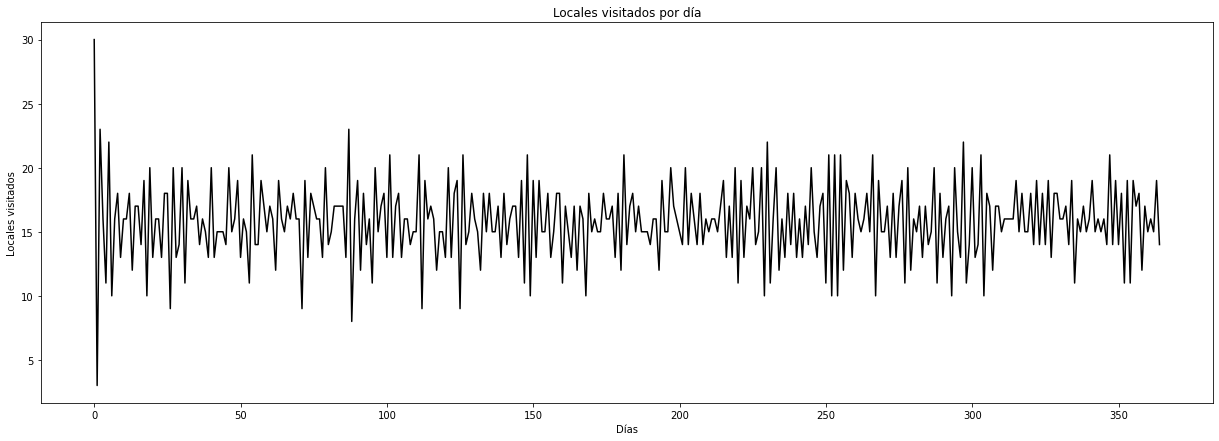

In [49]:
# graficaremos una serie de tiempo para el total de locales en cada día
# para esto, debemos sumar la cantidad de locales visitados en cada día, ya lo hicimos en la última columna

plt.figure(figsize=(21, 7))
plt.plot(df['sum'], '-', color='black')
plt.xlabel('Días')
plt.ylabel('Locales visitados')
plt.title('Locales visitados por día')
plt.show()

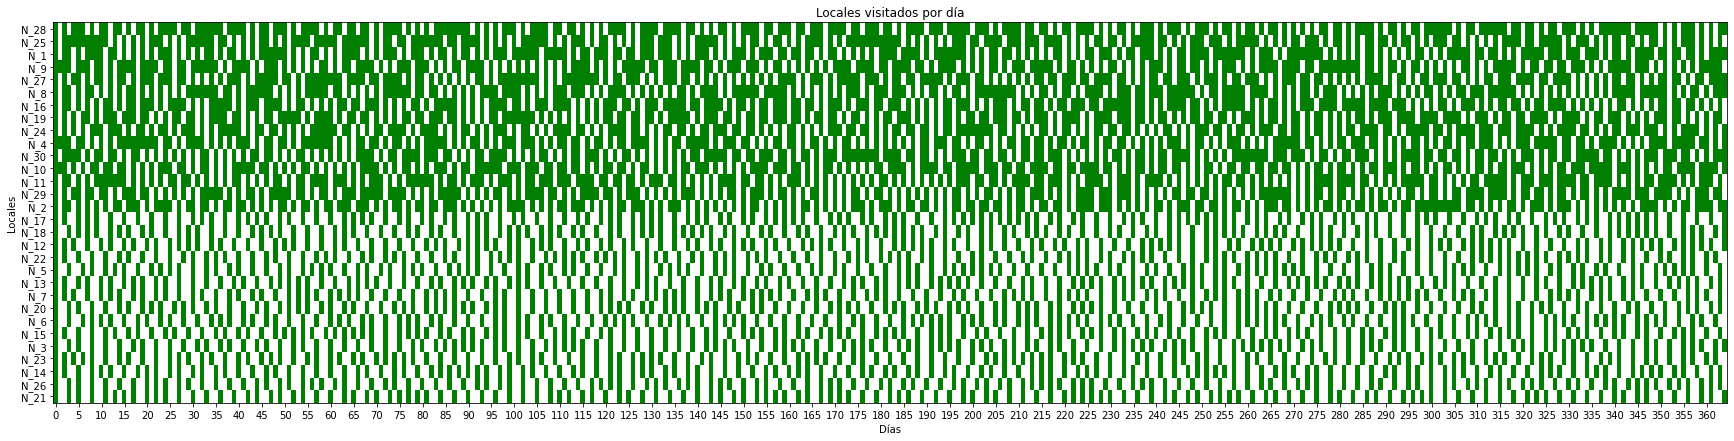

In [50]:

plotear_tablero_visitas(df, guardar = True, nombre = 'plots//tablero_n30_empty.png')

In [ ]:
cantidad_06 = len(df_nodos[df_nodos['frec'] >= 0.5])
cantidad_04 = len(df_nodos[df_nodos['frec'] < 0.5])

print (f'Locales visitados más de 50% de los días: {cantidad_06}, que corresponde a un {cantidad_06/N*100}%')
print (f'Locales visitados menos de 50% de los días: {cantidad_04}, que corresponde a un {cantidad_04/N*100}%')

Locales visitados más de 50% de los días: 15, que corresponde a un 50.0%
Locales visitados menos de 50% de los días: 15, que corresponde a un 50.0%


In [ ]:
def dispersion_intervalos(df):
    '''
    Función que calcula la cantidad promedio de días entre visitas a cada local.
    También entrega la desviación estándar de los intervalos.
    '''
    df = df.copy()
    if 'sum' in df.columns:
        df.drop('sum', axis=1, inplace=True)
    datos = {nodo: {'mean': None, 'std': None} for nodo in df.columns}
    for nodo in df.columns:
        largos = []
        ultima_visita = 0
        for dia in range(len(df)):
            if df[nodo][dia] == 1:
                if dia - ultima_visita > 3:
                    #print(f'El local {nodo} no fue visitado por {dia - ultima_visita} días')
                    pass
                largos.append(dia - ultima_visita)
                ultima_visita = dia
        datos[nodo]['mean'] = np.mean(largos)
        datos[nodo]['std'] = np.std(largos)
    datos_df = pd.DataFrame.from_dict(datos, orient='index')
    return datos_df

datos = dispersion_intervalos(df)
        

df_nodos['mean'] = datos['mean']
df_nodos['std'] = datos['std']
df_nodos['porcentaje demanda'] = df_nodos['dem_mean'] / df_nodos['Up']
df_nodos['porcentaje dem. inicial'] = df_nodos['Prod'] / df_nodos['Up']
df_nodos_corr = df_nodos[['Inv','Up','Low','Prod','h','frec','mean','std','dem_mean','porcentaje demanda','porcentaje dem. inicial']]


In [ ]:
df_nodos

,Inv,Up,Low,Prod,h,coord_x,coord_y,pos,frec,dem_mean,mean,std,porcentaje demanda,porcentaje dem. inicial
N_1,80,80,0,40,0.33,475,277,"(475, 277)",0.668493,39.966853,1.491803,0.499933,0.499586,0.500000
N_2,48,48,0,24,0.41,166,149,"(166, 149)",0.682192,24.014499,1.457831,0.498219,0.500302,0.500000
N_3,180,180,0,60,0.47,349,302,"(349, 302)",0.389041,59.903323,2.549296,0.497564,0.332796,0.333333
N_4,154,154,0,77,0.36,153,37,"(153, 37)",0.641096,77.157310,1.555556,0.496904,0.501021,0.500000
N_5,186,186,0,62,0.48,268,232,"(268, 232)",0.389041,61.897139,2.563380,0.495967,0.332780,0.333333
N_6,123,123,0,41,0.24,194,384,"(194, 384)",0.389041,41.016456,2.563380,0.495967,0.333467,0.333333
N_7,192,192,0,64,0.48,343,432,"(343, 432)",0.383562,63.887674,2.592857,0.491302,0.332748,0.333333
N_8,112,112,0,56,0.49,17,197,"(17, 197)",0.663014,56.150267,1.504132,0.499983,0.501342,0.500000
N_9,32,32,0,16,0.39,103,180,"(103, 180)",0.673973,16.020312,1.475610,0.499405,0.500635,0.500000
N_10,72,72,0,36,0.17,427,458,"(427, 458)",0.663014,36.082110,1.500000,0.500000,0.501140,0.500000


In [ ]:
df_nodos_corr.corr()

,Inv,Up,Low,Prod,h,frec,mean,std,dem_mean,porcentaje demanda,porcentaje dem. inicial
Inv,1.000000,1.000000,NaN,0.901948,-0.190532,-0.421994,0.425030,-0.071582,0.901470,-0.398811,-0.399134
Up,1.000000,1.000000,NaN,0.901948,-0.190532,-0.421994,0.425030,-0.071582,0.901470,-0.398811,-0.399134
Low,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Prod,0.901948,0.901948,NaN,1.000000,-0.270619,-0.036268,0.036805,-0.001479,0.999994,-0.007941,-0.008505
h,-0.190532,-0.190532,NaN,-0.270619,1.000000,-0.056623,0.068157,-0.086664,-0.270609,-0.062111,-0.062492
frec,-0.421994,-0.421994,NaN,-0.036268,-0.056623,1.000000,-0.999201,0.298047,-0.035177,0.996244,0.995978
mean,0.425030,0.425030,NaN,0.036805,0.068157,-0.999201,1.000000,-0.288965,0.035708,-0.996829,-0.996584
std,-0.071582,-0.071582,NaN,-0.001479,-0.086664,0.298047,-0.288965,1.000000,-0.000075,0.256283,0.253633
dem_mean,0.901470,0.901470,NaN,0.999994,-0.270609,-0.035177,0.035708,-0.000075,1.000000,-0.006928,-0.007515
porcentaje demanda,-0.398811,-0.398811,NaN,-0.007941,-0.062111,0.996244,-0.996829,0.256283,-0.006928,1.000000,0.999970
